## 手工实现一个线性回归的训练过程
- 1）手工定义数据的生成   synthetic_data
- 2）手工定义数据迭代器   data_iter
- 3）手工定义线性回归函数  linreg
- 4）手工定义损失函数      squared_loss
- 5）手工定义随机梯度下降的参数修正函数   sgd

最后使用标准的训练流程，完成线性回归的过程

In [3]:
%matplotlib inline
import random
import torch 


In [5]:
from d2l import torch as d2l

## 使用如下的公式产生数据样本，增加了一个epsilon的杂音
$$ y = Xw+b+\epsilon $$

In [6]:
def synthetic_data(w,b,num_examples):
    X = torch.normal(0,1,(num_examples,len(w)))
    y = torch.matmul(X,w)+b
    y+=torch.normal(0,0.01,y.shape)
    return X,y.reshape((-1,1))
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features , labels = synthetic_data(true_w,true_b,1000)

## 在二维图中展示数据，使用feature中的第“1”维度的数据
- 此处的detach在新的版本中已经不需要了

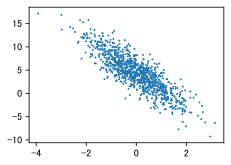

In [36]:
d2l.set_figsize()
# d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1)
d2l.plt.scatter(features[:,1].numpy(),labels.numpy(),1)

## 在iterator中yield 的使用

In [37]:
def data_iter(batch_size,features,labels):
    num_exm = len(features)
    indices  = list(range(num_exm))
    random.shuffle(indices)
    for i in range(0,num_exm,batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_exm)])
        yield features[batch_indices],labels[batch_indices]
batch_size=10
for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break

tensor([[-0.5837, -0.5144],
        [ 0.3065,  0.4209],
        [-1.2135,  0.3081],
        [-0.7123,  1.1452],
        [ 0.4264,  2.6621],
        [ 0.3367, -0.1944],
        [-0.2136, -0.0737],
        [ 0.5711, -0.0362],
        [ 0.7585,  0.6939],
        [-1.0684, -0.7193]]) 
 tensor([[ 4.7835],
        [ 3.3663],
        [ 0.7315],
        [-1.1167],
        [-4.0061],
        [ 5.5346],
        [ 4.0290],
        [ 5.4748],
        [ 3.3609],
        [ 4.5372]])


#### 使用normal函数，产生一个（2，1）的weights。使之符合（0，0.01）的正态分布。
- 此处的requires_grad是必须的，即使在pytorch1.7中也是如此.
- 在整个计算图中，只有参数需要grad，像X，y，y_hat都不需要。因为只有参数需要根据grad的值进行修正。


In [38]:
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)
# w = torch.normal(0,0.01,size=(2,1))
# b = torch.zeros(1)

#### 定义linreg的线性回归函数，用于训练参数w,b使之拟合我们的数据产生时的参数。

In [39]:
def linreg(X,w,b):
    return torch.matmul(X,w)+b

In [40]:
def squared_loss(y_hat,y):
    return(y_hat-y.reshape(y_hat.shape))**2/2

#### 定义sgd函数，实现参数（w，b）的随机梯度下降

In [41]:
def sgd(params,lr,batch_size):
    with torch.no_grad():         #torch.no_grad()使得如下的运算不会增加到计算图中。
        for param in params:
            param -= lr*param.grad/batch_size
            param.grad.zero_()

#### 此处使用了sum（），主要是使得我们的loss变成一个标量。是否可以使用mean（）呢？
- 测试结果是使用mean的话，学习过程会很慢，当然可以使lr变大一些来调整。

In [42]:
lr = 0.03
epochs = 5
net = linreg
loss = squared_loss
for epoch in range(epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y)
        l.sum().backward()
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch{epoch+1},loss{float(train_l.mean()):f}')

epoch1,loss0.030788
epoch2,loss0.000121
epoch3,loss0.000050
epoch4,loss0.000050
epoch5,loss0.000050


In [43]:
print(f'WuCha_w:{true_w - w.reshape(true_w.shape)}')
print(f'WuCha_b:{true_b - b}')


WuCha_w:tensor([-0.0001, -0.0002], grad_fn=<SubBackward0>)
WuCha_b:tensor([-0.0004], grad_fn=<RsubBackward1>)
